In [1]:
import pandas as pd                     # type: ignore
import matplotlib.pyplot as plt         # type: ignore
import matplotlib.gridspec as gridspec  # type: ignore

def convert_to_time(timesteps):
    tps = 80	# estimated value for timesteps per second
    return round(timesteps / tps, 2)

def label_bars(ax, bars, color):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/100.0, yval, f'{yval:.2f}', va='bottom', color=color)

# Read the file and extract the data
file_path = './logs/levelbeats.csv'
data = pd.read_csv(file_path, header=None, names=['completion_timesteps', 'training_timesteps', 'time_in_seconds'])

# Remove outliers from data, although keep in mind they do represent massive amounts of exploration at the beginning of training
dropped = 0
indexes = [index for index, win_time in enumerate(data['completion_timesteps']) if win_time > 150000]
for index in indexes:
    data = data.drop(index)
    print(f"Outlier dropped at index {index}")
    dropped += 1

# Find the split in the .csv between Pass 1 and Pass 2
with open(file_path, 'r') as file:
    lines = file.readlines()
split_index1 = lines.index('\n') - dropped
split_index2 = lines.index('\n', split_index1+1+dropped) - dropped -1
print("split_index1:", split_index1)
print("split_index2:", split_index2)

# Split the data corresponding to Pass 1 and Pass 2, find averages & 5 fastests
cutoff = 100
p1_completion_t = data['completion_timesteps'][:split_index1]
p2_completion_t = data['completion_timesteps'][split_index1:split_index2]
p3_completion_t = data['completion_timesteps'][split_index2:]
p1_training_t = data['training_timesteps'][:split_index1]
p2_training_t = data['training_timesteps'][split_index1:split_index2]
p3_training_t = data['training_timesteps'][split_index2:]

# Make sure dropping of indexes is correct
# print(p1_training_t)
# print(p2_training_t)
# print(p3_training_t)

# Acquire split data
average_pass1 = convert_to_time(p1_completion_t[-cutoff:].mean())
average_pass2 = convert_to_time(p2_completion_t[-cutoff:].mean())
average_pass3 = convert_to_time(p3_completion_t[-cutoff:].mean())
fastest_pass1 = data[:split_index1].nsmallest(5, 'completion_timesteps')
fastest_pass2 = data[split_index1:split_index2].nsmallest(5, 'completion_timesteps')
fastest_pass3 = data[split_index2:].nsmallest(5, 'completion_timesteps')

# Print out the data about the averages
print(f"Pass 1 average completion time: {convert_to_time(p1_completion_t.mean())} seconds")
print(f"Pass 2 average completion time: {convert_to_time(p2_completion_t.mean())} seconds")
print(f"Pass 3 average completion time: {convert_to_time(p3_completion_t.mean())} seconds")
print(f"Pass 1 average completion time for last {cutoff} wins: {average_pass1} seconds")
print(f"Pass 2 average completion time for last {cutoff} wins: {average_pass2} seconds")
print(f"Pass 3 average completion time for last {cutoff} wins: {average_pass3} seconds")

Outlier dropped at index 0
Outlier dropped at index 1
Outlier dropped at index 3
Outlier dropped at index 4
Outlier dropped at index 20
split_index1: 291
split_index2: 1052
Pass 1 average completion time: 124.69 seconds
Pass 2 average completion time: 66.31 seconds
Pass 3 average completion time: 41.82 seconds
Pass 1 average completion time for last 100 wins: 95.72 seconds
Pass 2 average completion time for last 100 wins: 49.06 seconds
Pass 3 average completion time for last 100 wins: 42.97 seconds


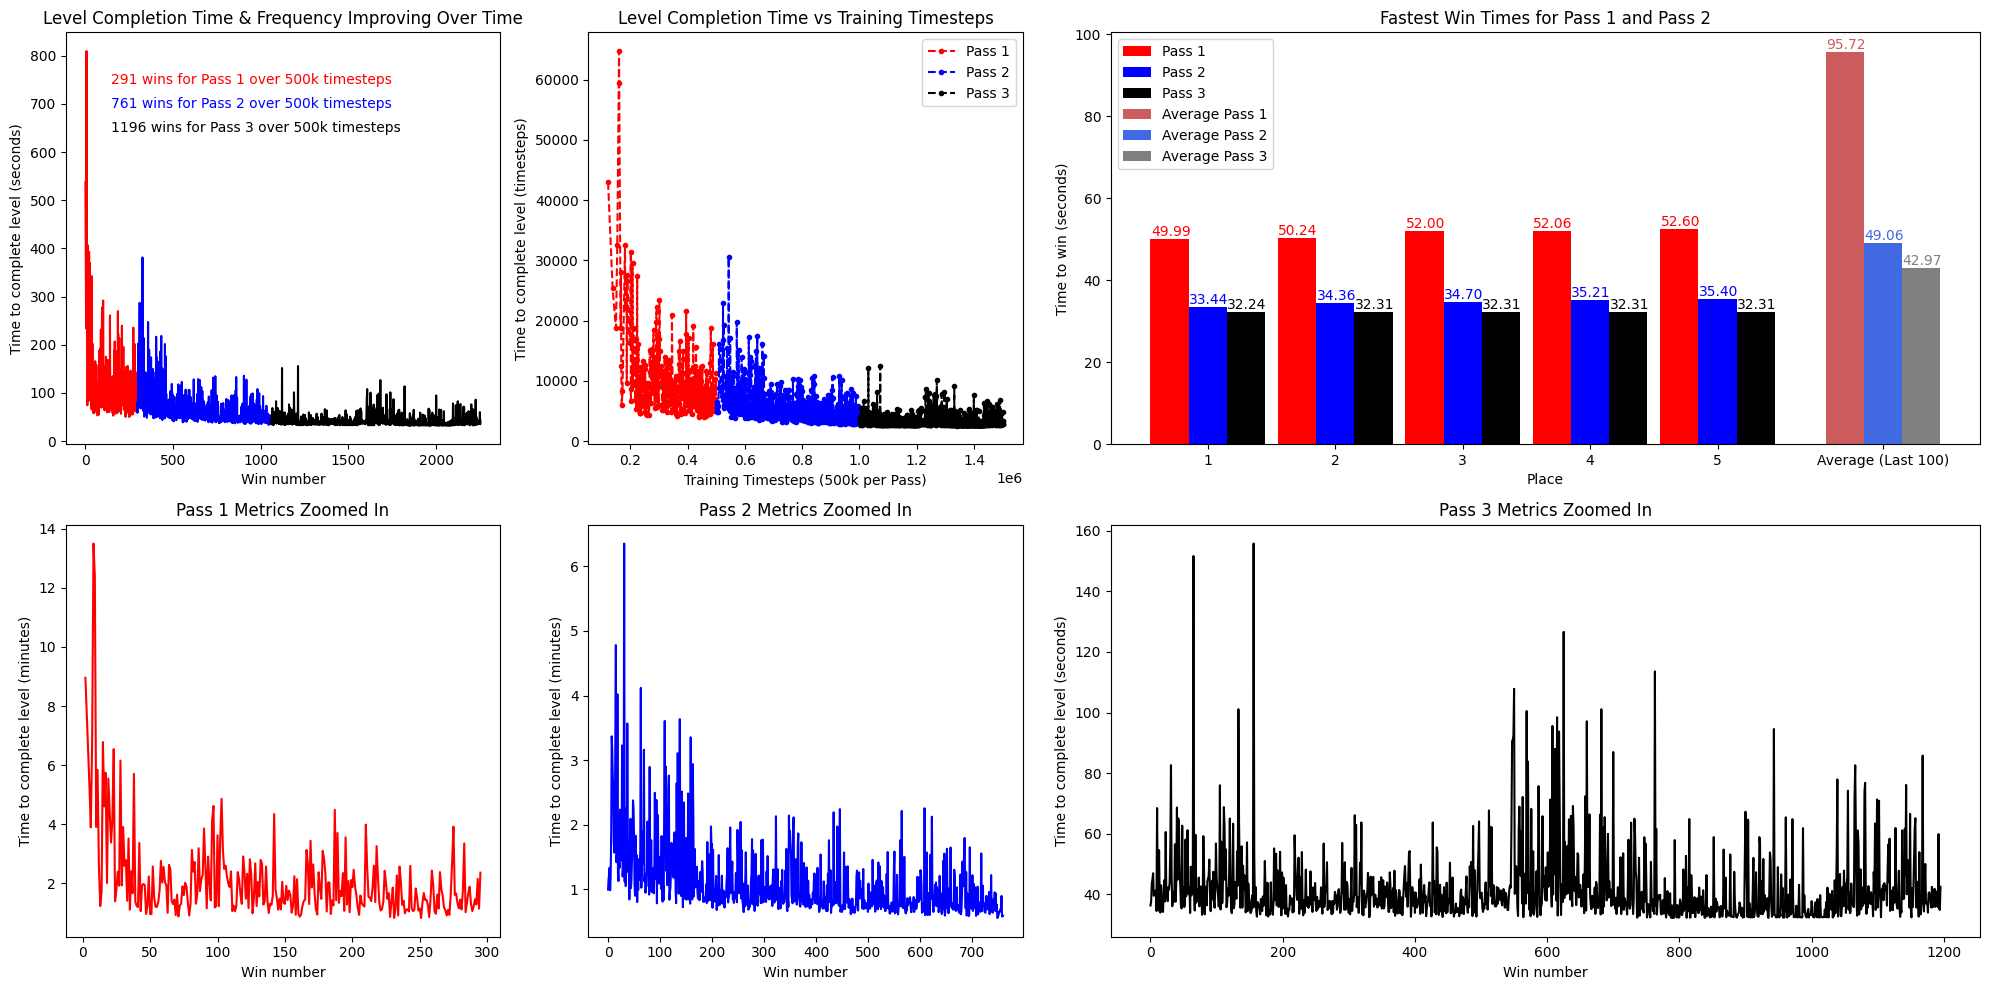

In [2]:
#Customization
p1_color = "red"
p2_color = "blue"
p3_color = "black"
p1_color_average = "indianred"
p2_color_average = "royalblue"
p3_color_average = "gray"

# Graph setup
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 2], height_ratios=[1, 1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])
ax4 = plt.subplot(gs[4])
ax5 = plt.subplot(gs[5])

# Graph level completion time and frequency improving over time
ax0.plot(convert_to_time(p1_completion_t), color=p1_color)
ax0.plot(convert_to_time(p2_completion_t), color=p2_color)
ax0.plot(convert_to_time(p3_completion_t), color=p3_color)
ax0.set_title('Level Completion Time & Frequency Improving Over Time')
ax0.set_ylabel('Time to complete level (seconds)')
ax0.set_xlabel('Win number')
ax0.text(150, 750, f'{len(p1_completion_t)} wins for Pass 1 over 500k timesteps', color=p1_color, verticalalignment='center', horizontalalignment='left')
ax0.text(150, 700, f'{len(p2_completion_t)} wins for Pass 2 over 500k timesteps', color=p2_color, verticalalignment='center', horizontalalignment='left')
ax0.text(150, 650, f'{len(p3_completion_t)} wins for Pass 3 over 500k timesteps', color=p3_color, verticalalignment='center', horizontalalignment='left')

# Graph level completion time vs training timesteps
ax1.plot(p1_training_t, p1_completion_t, linestyle='--', marker='.', label='Pass 1', color=p1_color)
ax1.plot(p2_training_t + 500000, p2_completion_t, linestyle='--', marker='.', label='Pass 2', color=p2_color)
ax1.plot(p3_training_t + 1000000, p3_completion_t, linestyle='--', marker='.', label='Pass 3', color=p3_color)
ax1.set_title('Level Completion Time vs Training Timesteps')
ax1.set_xlabel('Training Timesteps (500k per Pass)')
ax1.set_ylabel('Time to complete level (timesteps)')
ax1.legend(loc='upper right')

# Graph the bar chart, showing fastest speeds and average of the last 100 wins for each pass
width = 0.3
indices_pass1 = range(len(fastest_pass1))
indices_pass2 = [index + width for index in indices_pass1]
indices_pass3 = [index + width for index in indices_pass2]
bars1 =     ax2.bar(indices_pass1,                      convert_to_time(fastest_pass1['completion_timesteps']), width=width, label='Pass 1', color=p1_color)
bars2 =     ax2.bar(indices_pass2,                      convert_to_time(fastest_pass2['completion_timesteps']), width=width, label='Pass 2', color=p2_color)
bars3 =     ax2.bar(indices_pass3,                      convert_to_time(fastest_pass3['completion_timesteps']), width=width, label='Pass 3', color=p3_color)
bars1_avg = ax2.bar([max(indices_pass2) + 1],           [average_pass1],                                        width=width, label='Average Pass 1', color=p1_color_average)
bars2_avg = ax2.bar([max(indices_pass2) + 1 + width],   [average_pass2],                                        width=width, label='Average Pass 2', color=p2_color_average)
bars3_avg = ax2.bar([max(indices_pass3) + 1 + width],   [average_pass3],                                        width=width, label='Average Pass 3', color=p3_color_average)
label_bars(ax2, bars1, p1_color)
label_bars(ax2, bars2, p2_color)
label_bars(ax2, bars3, p3_color)
label_bars(ax2, bars1_avg, p1_color_average)
label_bars(ax2, bars2_avg, p2_color_average)
label_bars(ax2, bars3_avg, p3_color_average)
ax2.set_xticks(list(indices_pass2) + [max(indices_pass3) + 1])                          # Set x-ticks to indices and "Average" position
ax2.set_xticklabels(list(range(1, len(fastest_pass1) + 1)) + [f'Average (Last {cutoff})'])    # Set x-tick labels to index numbers and "Average"
ax2.set_title('Fastest Win Times for Pass 1 and Pass 2')
ax2.set_ylabel('Time to win (seconds)')
ax2.set_xlabel('Place')
ax2.legend()

# Graph the zoomed in metrics for each pass
ax3.plot(convert_to_time(p1_completion_t) / 60, color=p1_color)
ax3.set_title('Pass 1 Metrics Zoomed In')
ax3.set_ylabel('Time to complete level (minutes)')
ax3.set_xlabel('Win number')
x_values = range(len(convert_to_time(p2_completion_t)))
ax4.plot([x for x in x_values], convert_to_time(p2_completion_t) / 60, color=p2_color)
ax4.set_title('Pass 2 Metrics Zoomed In')
ax4.set_ylabel('Time to complete level (minutes)')
ax4.set_xlabel('Win number')
x_values = range(len(convert_to_time(p3_completion_t)))
ax5.plot([x for x in x_values], convert_to_time(p3_completion_t), color=p3_color)
ax5.set_title('Pass 3 Metrics Zoomed In')
ax5.set_ylabel('Time to complete level (seconds)')
ax5.set_xlabel('Win number')

# Show the graph
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()